### Testing the outputs from Synpipe

Synpipe is a pipeline to insert synthetic sources into imaging data (originally designed for HSC data). Details can be found at: https://arxiv.org/abs/1705.01599

The data we are exploring is HSC imaging of the galaxy IC 1613 from Jeff Carlin's research. Nate Lust has run Synpipe on these data, inserting artificial stars in all the images, and extracted the resulting catalogs into .fits files. In this notebook, we focus on the .fits catalogs rather than butler repos.

In [128]:
from astropy.io import fits
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Setup plot defaults to make nicer looking figures:
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelweight'] = 3
plt.rcParams['axes.titleweight'] = 3
plt.rcParams['figure.figsize'] = (9, 7)


In [129]:
# Read a catalog that contains only the fake stars from a single patch:
# This catalog should contain all of the matches of fake stars to objects in the measured catalog.
# Note that this does not mean that it contains all input fake stars -- only those with a match in the output repo.

# hdulist = fits.open("/project/jcarlin/ic1613_synpipe/ic_fakes_only/g_10,14.fits.fits") # a single patch
hdulist = fits.open("/project/mreuter/ic_fakes_cat/g_8-12,12-16.fits") # a few patches
data = hdulist[1].data

In [130]:
# Read a catalog that lists the fake stars that were input:
# NOTE: this contains stars over the entire observed field.
hdu_all = fits.open('/project/jcarlin/ic1613_synpipe/ic_fake_catalogs/src_0_radec_G.fits')
data_all = hdu_all[1].data


In [131]:
# Create arrays of RA, Dec:
ra = data['coord_ra']
dec = data['coord_dec']

ra_all = data_all['RA']
dec_all = data_all['Dec']

In [132]:
# We'll work with only objects in the outputs that satisfy the "detect_isPrimary" flag:
is_primary = data['detect_isPrimary'] #& (data['parent'] > 0)

In [133]:
# Extract the measured PSF flux and magnitude zeropoint (a constant 27.0 for all objects, but we'll grab it in case...)
psf_flux = data['base_PsfFlux_flux'][is_primary]
zeropoint = data['zeropoint'][is_primary]

In [134]:
# Calculate PSF magnitudes:
psf_mags = -2.5 * np.log10(psf_flux) + zeropoint

In [135]:
# Extract the fake input mags:
fake_mags = data['mag'][is_primary]

### Compare the input (fake) magnitudes and measured PSF mags:

In [136]:
diff_mags = psf_mags - fake_mags

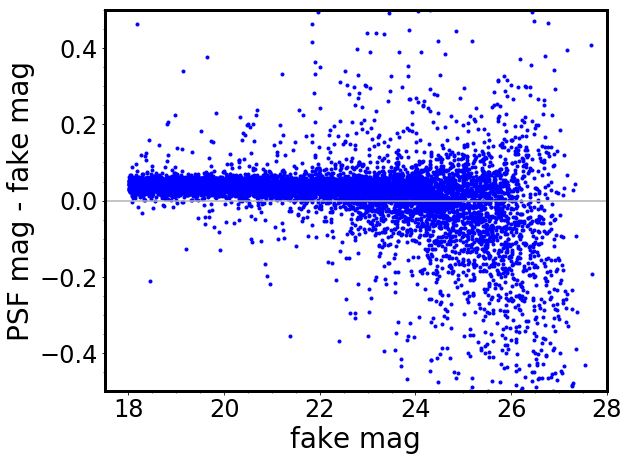

In [137]:
plt.figure()
plt.plot(fake_mags, diff_mags, 'b.')
tmp = np.arange(14,30)
plt.plot(tmp,0.0*tmp,color='0.7')
plt.ylim(-0.5,0.5)
#plt.ylim(-1.5,1.5)
plt.xlim(17.5,28.0)
plt.xlabel('fake mag')
plt.ylabel('PSF mag - fake mag')
plt.minorticks_on()

### Completeness as a function of magnitude

In [138]:
# Of the input fake stars, how many were recovered?

magbins = np.arange(18., 28., 0.25)

# bin the PSF magnitudes:
mags_hist = np.histogram(psf_mags, magbins)

# bin the fake magnitudes:
fake_mags_clean_hist = np.histogram(fake_mags, magbins)

# Calculate the centers of the bins:
bin_centers = (mags_hist[1][:-1] + mags_hist[1][1:]) / 2.


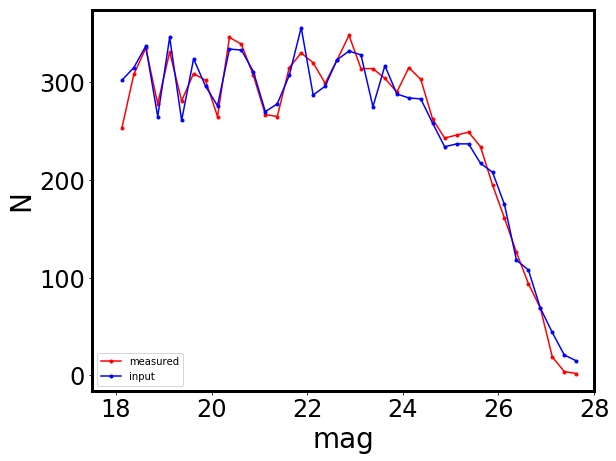

In [139]:
# Total number of stars in the bins:
plt.figure()
plt.plot(bin_centers, mags_hist[0], 'r.-',label='measured')
plt.plot(bin_centers, fake_mags_clean_hist[0], 'b.-',label='input')
#plt.ylim(-0.5,0.5)
#plt.ylim(-1.5,1.5)
plt.xlim(17.5,28.0)
plt.xlabel('mag')
plt.ylabel('N')
plt.legend(loc='lower left')

In [140]:
# Because the input catalog covers a large field of view,
# and we're looking at a smaller region, we need to pick
# out this region based on RA, Dec coordinates:

minra, maxra = np.min(ra[is_primary]), np.max(ra[is_primary])
mindec, maxdec = np.min(dec[is_primary]), np.max(dec[is_primary])

inbbox = (ra_all > minra) & (ra_all< maxra) &\
         (dec_all > mindec) & (dec_all < maxdec)

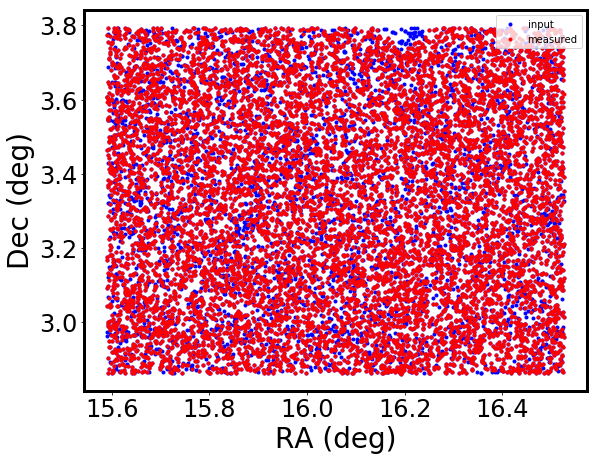

In [141]:
# Where are the sources in RA, Dec?
plt.figure()
plt.plot(ra_all[inbbox],dec_all[inbbox],'b.',label='input')
plt.plot(ra[is_primary],dec[is_primary],'r.',label='measured')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.legend()

In [142]:
# To find the completeness, bin magnitudes of input (fake) stars aand compare to the number in binned measred mags:

fake_mags_all_hist = np.histogram(data_all['mag'][inbbox], magbins)

# Completeness is # found vs. number input in each bin:
completeness_all = mags_hist[0] / fake_mags_all_hist[0]
completeness_all2 = fake_mags_clean_hist[0] / fake_mags_all_hist[0]

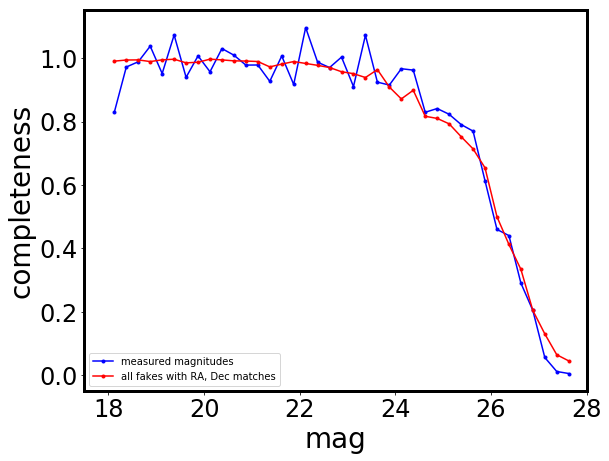

In [143]:
plt.figure()
plt.plot(bin_centers, completeness_all, 'b.-', label='measured magnitudes')
plt.plot(bin_centers, completeness_all2, 'r.-', label='all fakes with RA, Dec matches')
plt.xlim(17.5,28.0)
plt.xlabel('mag')
plt.ylabel('completeness')
plt.legend(loc='lower left')